In [131]:
import numpy as np
import torch
import matplotlib.pyplot as plt

torch.Size([260, 1])

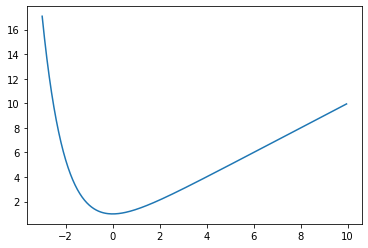

In [140]:
xs = torch.arange(-3, 10, 0.05)
ys = 1/torch.exp(xs) + xs
#xs = torch.arange(-5, 5, 0.05)
#ys = torch.sin(xs) + xs
plt.plot(xs, ys)
xs.unsqueeze_(1)
xs.shape

In [149]:
# Functions
from torch.distributions import StudentT

def reduce(val, reduction):
    if reduction == 'mean':
        val = val.mean()
    else:
        raise ValueError(f"Invalid reduction argument: {reduction}")
    return val

def NIG_NLL(y: torch.Tensor,
            gamma: torch.Tensor,
            nu: torch.Tensor,
            alpha: torch.Tensor,
            beta: torch.Tensor, reduction='mean'):
    student_var = beta * (1. + alpha) / (nu * alpha)
    dist = StudentT(loc=gamma, scale=student_var, df=2*alpha)
    nll = -1 * dist.log_prob(y)
    return reduce(nll, reduction=reduction)

def NIG_Reg(y, gamma, nu, alpha, reduction='mean'):
    error = (y - gamma).abs()
    evidence = 2. * nu + alpha
    return reduce(error * evidence, reduction=reduction)

def EvidentialRegression(y: torch.Tensor, evidential_output: torch.Tensor, lmbda=1.):
    gamma, nu, alpha, beta = evidential_output
    loss_nll = NIG_NLL(y, gamma, nu, alpha, beta)
    loss_reg = NIG_Reg(y, gamma, nu, alpha)
    return loss_nll + lmbda * loss_reg

from torch.nn import Module
import torch.nn.functional as F

class DenseNormalGamma(Module):
    def __init__(self, n_input, n_out_tasks=1):
        super(DenseNormalGamma, self).__init__()
        self.n_in = n_input
        self.n_out = 4 * n_out_tasks
        self.n_tasks = n_out_tasks
        self.l1 = nn.Linear(self.n_in, self.n_out)

    def forward(self, x):
        x = self.l1(x)
        if len(x.shape) == 1:
            gamma, lognu, logalpha, logbeta = torch.split(x, self.n_tasks, dim=0)
        else:
            gamma, lognu, logalpha, logbeta = torch.split(x, self.n_tasks, dim=1)

        nu = F.softplus(lognu)
        alpha = F.softplus(logalpha) + 1.
        beta = F.softplus(logbeta)

        return torch.stack([gamma, nu, alpha, beta]).to(x.device)

In [152]:
from torch import nn
class BasicNetwork(torch.nn.Module):
    def __init__(self, n_in=1, n_tasks=1):
        super(BasicNetwork, self).__init__()
        self.l1 = torch.nn.Linear(n_in, 20)
        self.l2 = torch.nn.Linear(20, 20)
        self.l3 = DenseNormalGamma(20, 1)
        
    def forward(self, x):
        x = self.l1(x)
        x = torch.nn.functional.tanh(x)
        x = self.l2(x)
        x = torch.nn.functional.tanh(x)
        x = self.l3(x)
        return x

In [154]:
model = BasicNetwork()
#optim = torch.optim.Adam(model.parameters(), lr=1e-2)
optim = torch.optim.LBFGS(model.parameters(), lr=1e-1)
for i in range(36):
    def closure():
        loss = 0.
        for x, y in zip(xs, ys):
            output = model(x)
            loss += EvidentialRegression(y, output)
        print(f"Step {i}: ", loss.item())
        optim.zero_grad()
        loss.backward()
        return loss
    optim.step(closure)

Step 0:  5582.78173828125
Step 0:  5551.7607421875
Step 0:  4884.78271484375
Step 0:  4025.001953125
Step 0:  3681.357421875
Step 0:  3422.216064453125
Step 0:  3124.6455078125
Step 0:  2786.245849609375
Step 0:  2609.587890625
Step 0:  2472.33642578125
Step 0:  2317.31787109375
Step 0:  2148.353271484375
Step 0:  1997.5634765625
Step 0:  1843.1070556640625
Step 0:  1707.774658203125
Step 0:  1594.32080078125
Step 0:  1481.2662353515625
Step 0:  1350.9033203125
Step 0:  1130.1134033203125
Step 0:  920.1446533203125
Step 1:  917.6504516601562
Step 1:  877.5499877929688
Step 1:  890.4469604492188
Step 1:  851.8070068359375
Step 1:  791.2943725585938
Step 1:  691.0645141601562
Step 1:  620.87158203125
Step 1:  613.5509643554688
Step 1:  609.0616455078125
Step 1:  603.4412231445312
Step 1:  595.3903198242188
Step 1:  587.7646484375
Step 1:  580.9413452148438
Step 1:  573.3193969726562
Step 1:  568.0383911132812
Step 1:  561.0546264648438
Step 1:  555.0177001953125
Step 1:  548.881591796875

Step 14:  -944.9783325195312
Step 14:  -945.5042724609375
Step 14:  -945.794189453125
Step 14:  -946.1536254882812
Step 15:  -946.4766845703125
Step 15:  -946.686279296875
Step 15:  -946.8535766601562
Step 15:  -947.016845703125
Step 15:  -947.1891479492188
Step 15:  -947.37548828125
Step 15:  -947.5546875
Step 15:  -947.7318725585938
Step 15:  -947.9681396484375
Step 15:  -948.2034912109375
Step 15:  -948.4478149414062
Step 15:  -948.6375732421875
Step 15:  -948.8513793945312
Step 15:  -949.0626831054688
Step 15:  -949.2706298828125
Step 15:  -949.4677124023438
Step 15:  -949.6600341796875
Step 15:  -949.8252563476562
Step 15:  -949.9837036132812
Step 15:  -950.15380859375
Step 16:  -950.2874755859375
Step 16:  -950.4240112304688
Step 16:  -950.560546875
Step 16:  -950.6911010742188
Step 16:  -950.79931640625
Step 16:  -950.931884765625
Step 16:  -951.0330200195312
Step 16:  -951.155029296875
Step 16:  -951.2562866210938
Step 16:  -951.38037109375
Step 16:  -951.48876953125
Step 16:  

Step 29:  -984.373046875
Step 29:  -984.5233154296875
Step 29:  -984.6748657226562
Step 29:  -984.8272094726562
Step 29:  -984.9888916015625
Step 29:  -985.1676635742188
Step 29:  -985.341796875
Step 29:  -985.570068359375
Step 29:  -985.7971801757812
Step 29:  -985.985107421875
Step 29:  -986.120361328125
Step 29:  -986.27587890625
Step 29:  -986.407470703125
Step 29:  -986.5847778320312
Step 29:  -986.7578735351562
Step 29:  -986.908447265625
Step 30:  -987.05029296875
Step 30:  -987.220947265625
Step 30:  -987.3656616210938
Step 30:  -987.5484619140625
Step 30:  -987.6907958984375
Step 30:  -987.8900146484375
Step 30:  -988.060546875
Step 30:  -988.2185668945312
Step 30:  -988.4310302734375
Step 30:  -988.613037109375
Step 30:  -988.802978515625
Step 30:  -988.9926147460938
Step 30:  -989.17626953125
Step 30:  -989.3685302734375
Step 30:  -989.5755615234375
Step 30:  -989.78662109375
Step 30:  -990.0014038085938
Step 30:  -990.2368774414062
Step 30:  -990.6483764648438
Step 30:  -99

In [155]:
# Prediction

y_hat = []
y_aleatoric = []
y_epistemic = []
for x in xs:
    output = model(x)
    gamma, nu, alpha, beta = output
    gamma, nu, alpha, beta = gamma.item(), nu.item(), alpha.item(), beta.item()
    y_hat.append(gamma)
    y_aleatoric.append(beta/(alpha-1))
    y_epistemic.append(beta/(alpha-1)/nu)
y_hat = np.array(y_hat)
y_aleatoric = np.array(y_aleatoric)
y_epistemic = np.array(y_epistemic)

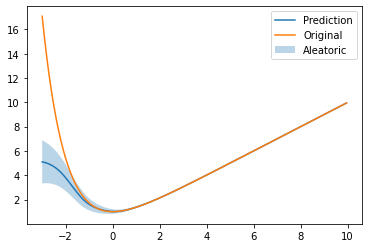

In [158]:
plt.plot(xs, y_hat, label='Prediction')
plt.plot(xs, ys, label='Original')
plt.fill_between(xs[:,0], y_hat-3*y_aleatoric, y_hat+3*y_aleatoric, alpha=0.3, label='Aleatoric')
#plt.fill_between(xs[:,0], y_hat-3*y_epistemic, y_hat+3*y_epistemic, alpha=0.3, label='Epistemic')

plt.legend()